# TSSaliencyExplainer For Univariate

Time Series Saliency (TSSaliency) Explainer is a model agnostic saliency explainer for time series associate tasks. The saliency supports univariate and multivariate use cases. It explains temporal importance of different variates on the model prediction. TSSaliency incorporates an integrated gradient method for saliency estimation and, therefore, provides reasonable values for functions that are continuous, and differentiable almost everywhere. It may be ill-suited to certain types of ensemble models such as Random Forests. The saliency measure involves the notion of a base value. For example, the base value can be the constant signal with average value. The saliency measure is computed by integrating the model sensitivity over a trajectory from the base value to the time series signal. The TSSaliency explainer provides variate wise contributions to model prediction at a temporal resolution.

This notebook demonstrates usage of TSSaliencyExplainer for Univariate data using [FordA dataset](http://www.timeseriesclassification.com/description.php?Dataset=FordA).

<a id='notebook_workflow'></a>
## Notebook Workflow
- [Imports](#imports)
- [Load Dataset](#load_dataset)
- [Train Classifier](#train_classifier)
- [Initialize TSSaliencyExplainer](#initialize_tssaliency)
- [Compute Explanation](#compute_explanation)
- [Plot Explanation](#plot_explanation)

<a id='imports'></a>
### Imports

The example model is a pre-trained keras model and hosted on huggingface hub. So, this notebook requires to install tensorflow 2.4+ and huggingface_hub packages.

In [ ]:
!pip install huggingface_hub

In [1]:
import os
# to suppress unrelated tensorflow warnings while importing aix360.datasets
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from huggingface_hub import from_pretrained_keras
from aix360.datasets import FordDataset
from aix360.algorithms.tsutils.tsframe import tsFrame
from aix360.algorithms.tsutils.model_wrappers import Tensor_Based_Classification_Model
from aix360.algorithms.tssaliency.tssaliency import TSSaliencyExplainer
from huggingface_hub.utils import logging as h_logging

# huggingface hub warnings
h_logging.set_verbosity_error()

# tensorflow warnings
logger = tf.get_logger()
logger.setLevel(logging.ERROR)


<a id='load_dataset'></a>
### Load Dataset

The dataset is from [UCR archive](), [timeseriesclassification Datasets](http://www.timeseriesclassification.com/description.php?Dataset=FordA) and was used in IEEE World Congress on Computational Intelligence, 2008. As described in the prior websites, the classification problem is to diagnose whether a certain symptom exists or does not exist in an automotive subsystem. Each case consists of 500 measurements of engine noise and a classification. There are two separate problems. The current notebook uses FordA dataset. Train and test data sets were collected in typical operating conditions, with minimal noise contamination. 

In [2]:
input_length = 500
x_train, x_test, y_train, y_test = FordDataset().load_data()

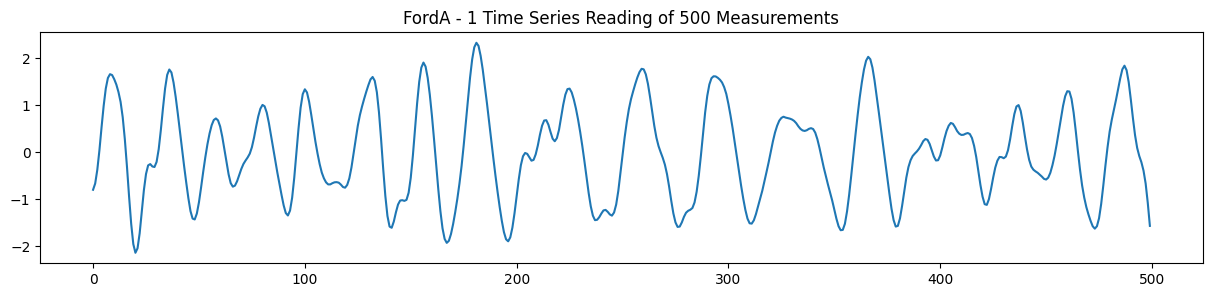

In [3]:
_ = pd.DataFrame(x_train[0]).plot(figsize=(15, 3), title="FordA - 1 Time Series Reading of 500 Measurements", legend=False)

<a id='train_classifier'></a>
### Download Pre-Trained Model
Use a pre-trained model from Keras/HuggingFace.

The pre-trained model is from: https://keras.io/examples/timeseries/timeseries_transformer_classification/
The Hugging face model url is: https://huggingface.co/keras-io/timeseries_transformer_classification

In [4]:
model = from_pretrained_keras("keras-io/timeseries_transformer_classification")

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

In [5]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 500, 1)]     0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 500, 1)      2           ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 500, 1)      7169        ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                                                                              

As the model inputs are tensor based, we are selecting Tensor_Based_Classification_Model from aix360 to wrap the model. The wrapper manages the input and output shapes between the original model and the explainer.

In [6]:
class_pos = 0 # to select class probability for explanation
binary_model = Tensor_Based_Classification_Model(model, 
                                                 class_pos=class_pos, 
                                                 input_length=input_length, 
                                                 n_features=1)


Model accuracy for selected test samples.

In [7]:
from sklearn.metrics import accuracy_score

test_sample_size = 10
y_pred = binary_model.predict(x_test[0:test_sample_size,...], verbose=0)

print("model accuracy for {} samples: {}.".format(test_sample_size, accuracy_score(y_test[:test_sample_size], y_pred.astype(int))))

model accuracy for 10 samples: 0.9.


<a id='initialize_tssaliency'></a>
### Initialize TSSaliencyExplainer
TSSaliencyExplainer uses integrated gradients over the input timeseries to compute saliency metric. If user brings their own gradient computation function, it can be used using parameter `gradient_function`. By default, `aix360.algorithms.tssaliency.gradient.mc_gradient_compute` is used. Increasing "n_samples" and "gradient_samples" increases quality of explanation.

In [8]:
import functools

explainer = TSSaliencyExplainer(model= functools.partial(binary_model.predict_proba, verbose = 0),
                        input_length= x_test.shape[1],
                        feature_names=['x'],
                        n_samples=50,
                        gradient_samples=100,
                               )

<a id='compute_explanation'></a>
### Compute Explanation

Compute saliency metric for a given input timeseries. Base value is required for explanation computation and can be provided during initialization of the explainer or during explanation computation. Default is to compute mean of the signal.

In [9]:
indx = 3
instance = x_test[indx, ...]
base_value = np.mean(instance, axis=0) # base value 

ts_instance = tsFrame(instance) # tsFrame instance
ts_instance.index = pd.to_numeric(ts_instance.index)
ts_instance

,X_1
time,
0,1.240282
1,1.331189
2,1.386596
3,1.383220
4,1.305979
...,...
495,-1.146352
496,-1.011328
497,-0.931222


In [10]:
explanation = explainer.explain_instance(ts_instance, base_value=base_value)

By Proposition 1 in "section 3 Mukund Sundararajan et al. Axiomatic Attribution for Deep Networks", sum of saliency scores (Integrated Gradient) and model prediction delta (`f(instance) - f(base)`) between the input instance and the base value should be zero. As the value is closer to zero, quality of explanation is high.

In [11]:
instance_prediction = explanation["instance_prediction"]
base_value_prediction = explanation["base_value_prediction"]

pred_delta = instance_prediction - base_value_prediction
saliency_sum = np.sum(explanation['saliency'])

print("Sum of Saliency scores (Integrated Gradient): {}".format(saliency_sum))
print("f(instance) - f(base): {}".format(pred_delta))
print("|f(instance) - f(base) - sum IG|: {}".format(np.abs(pred_delta - saliency_sum)))


Sum of Saliency scores (Integrated Gradient): -0.4495744055396319
f(instance) - f(base): [-0.48889413]
|f(instance) - f(base) - sum IG|: [0.03931972]


|f(instance) - f(base) - sum IG| value is reasonably close to zero which guarantees the computed integrated gradient.

<a id='plot_explanation'></a>
### Plot Explanation

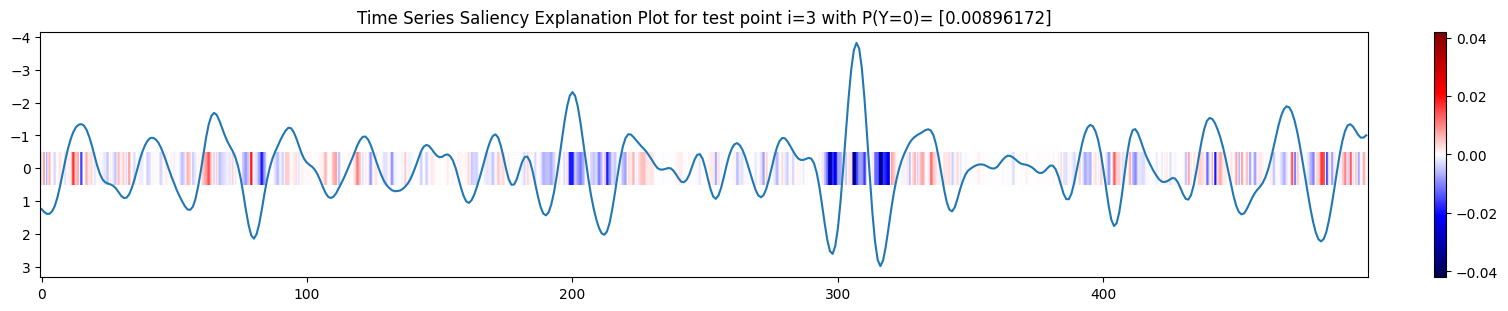

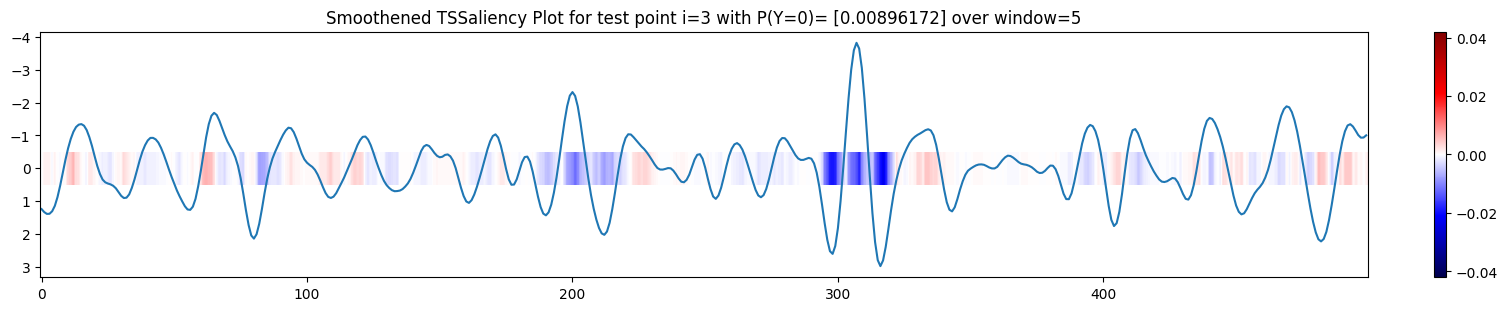

In [12]:

def plot_explanation(scores, title, vmax):
    figsize = (15,3)
    plt.figure(figsize=figsize, layout='constrained')
    plt.imshow(scores[np.newaxis,:],aspect='auto',cmap='seismic',vmin=-vmax,vmax=vmax)
    plt.colorbar()
    plt.plot(instance)
    plt.title(title)
    plt.show()

# plot tssaliency explanation for the test point
max_abs = np.max(np.abs(explanation['saliency']))
plot_explanation(scores=explanation['saliency'], 
                 title="Time Series Saliency Explanation Plot for test point i={} with P(Y={})= {}".format(str(indx), str(class_pos), str(instance_prediction)),
                 vmax=max_abs)

# plot smoothened tssaliency explanation for the test point
window = 5
convolve_saliency = np.convolve(explanation['saliency'].flatten(), np.ones(window), mode='same') / window

plot_explanation(scores=convolve_saliency, 
                 title="Smoothened TSSaliency Plot for test point i={} with P(Y={})= {} over window={}".format(str(indx), str(class_pos), str(instance_prediction), str(window)),
                 vmax=max_abs)



Negative saliency score (blue colored region) implies that the model prediction changes in opposite direction as feature value changes at respective time points.

Positive saliency score (red colored region) implies that the model prediction changes in same direction as feature value changes at respective time points.